# Packages and function

In [7]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, constants

# import functions required for processing of FRS data
import frsprocessing as frs
import SpectralData as SD

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input/Output

In [8]:
# import and load FRS traces
metafile = pd.read_excel(r"data\ISA1 raw data\FRSMetaInfoSet.xlsx", sheet_name='FRSMetaInfoSet', converters={'sample_name':str}) # read metafile

df_ref = pd.read_csv(r'data\ISA1 raw data\td_ref.csv', index_col=0) # load reference td traces
df_sam = pd.read_csv(r'data\ISA1 raw data\td_sam.csv', index_col=0) # load sample td traces

t_raw = df_ref.columns.astype('float') # dataframe index
td_ref_raw = df_ref.to_numpy() # converts data frame to matrix
td_sam_raw = df_sam.to_numpy() # converts data frame to matrix

# TOC Graphic

(Text(0.5, 0, 'Time (fs)'), Text(0, 0.5, 'Normalized EOS'))

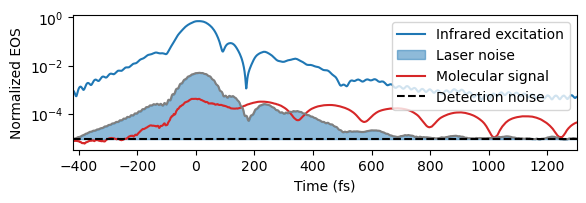

In [9]:
# calculate the referenced sample response hc from the raw td-data
t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw)

idx_f1, idx_f2 = (np.abs(freq - 900)).argmin(), (np.abs(freq - 1500)).argmin() # set limits of the filter in wavenumbers
idx_t1, idx_t2 = (np.abs(t - -420)).argmin(), (np.abs(t - 1300)).argmin() # set limits of the filter in wavenumbers

# select all measurements of 100ug/ml concentration at one specific measurement day
index = metafile[(metafile["sequence ID"] == 1667) & (metafile["Conc [ug/ml]"] == 100)].index.to_numpy()

# calc mean and difference traces, td-noise and the pulse envelope
td_ref_mean = np.mean(td_ref[index],axis=0)
td_sam_mean = np.mean(td_sam[index],axis=0)
td_diff_mean = td_ref_mean - td_sam_mean
td_noise = signal.savgol_filter(np.std(td_ref[index],axis=0), 101,2) # relative intensity noise - smoothed for better appearance
td_env = np.abs(signal.hilbert(td_ref_mean)) # pulse envelope
td_env_diff = signal.savgol_filter(np.abs(signal.hilbert(td_diff_mean)), 101,2) # pulse envelope of the molecular signal


### plotting ###

fig, ax = plt.subplots(1, figsize= (4*3.25/2,2*1.75/2)) # paper version

ax.semilogy(t[idx_t1:idx_t2], td_env[idx_t1:idx_t2], label='Infrared excitation')
ax.fill_between(t[idx_t1:idx_t2], 9e-6, td_noise[idx_t1:idx_t2], color='tab:blue',alpha=0.5, label='Laser noise')
ax.plot(t[idx_t1:idx_t2], td_env_diff[idx_t1:idx_t2], color='tab:red', label = 'Molecular signal')
ax.semilogy(t[idx_t1:idx_t2], td_noise[idx_t1:idx_t2], color='tab:gray')
ax.axhline(y=9e-6, color='k', linestyle='--', label='Detection noise')
#ax.fill_between(t[idx_t1:idx_t2], 9e-6, td_noise[idx_t1:idx_t2], color='tab:blue',alpha=0.5, label='Laser noise')

ax.legend()
ax.set_xlim(-420,1300)
ax.set_xlabel("Time (fs)"), ax.set_ylabel("Normalized EOS")

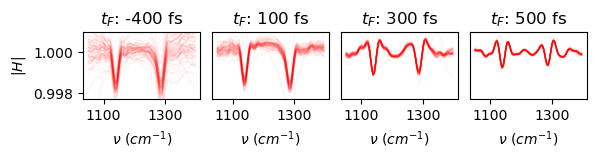

In [10]:
t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw, noecho=True) # cut out the pulse echo in the original td trace to remove oscillationsin the sample transfer function

Data =  SD.SpectralData(freq, hc, data_type='hc') # create spectral dataset object
idx_f1, idx_f2 = (np.abs(freq - 1050)).argmin(), (np.abs(freq - 1400)).argmin() # set plot/evalution range

times =  [-400, 100, 300, 500]

index  = metafile[metafile["Conc [ug/ml]"] == 100.0].index.to_numpy()
fig, axs = plt.subplots(1, 4, figsize= (4*3.25/2,1*1.75/2)) # small version
for i, ax in enumerate(axs.flat):
        Data.tdf(times[i],w_f=SD.tukeyF(freq,950,1450,25))
        hc_FF = Data.data
        _, hc_FF, _ = frs.pathlengthcorrection(metafile,hc, hc_FF,idx_f1,idx_f2,1667) 
        #ax.plot(freq[idx_f1:idx_f2],np.mean(np.abs(hc[index,idx_f1:idx_f2]),axis=0), 'k', alpha=1, lw=1)
        ax.plot(freq[None,idx_f1:idx_f2].T,np.abs(hc_FF[index,idx_f1:idx_f2]).T, 'r', alpha=0.05, lw=1)
        ax.set_title('$t_F$: '+str(times[i]) +' fs')
        ax.set_xlabel("$\\nu$ ($cm^{-1}$)")
        ax.set_ylim(0.9977,1.001)
        ax.set_xticks([1100,1300])
        if i:
                ax.set_yticks([])
                
        
axs[0].set_ylabel("$|H|$")
plt.subplots_adjust(wspace=0.1)